In [58]:
# 导入依赖库
import pandas as pd
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error

In [59]:
# 加载健康指标数据
def load_hi_from_csv(train_file_path="train_HI.csv", test_file_path="test_HI.csv"):
    train_df = pd.read_csv(train_file_path)
    test_df = pd.read_csv(test_file_path)
    print(f"Training HI loaded from {train_file_path}")
    print(f"Testing HI loaded from {test_file_path}")
    return train_df, test_df

In [60]:
# 加载数据
train_df, test_df = load_hi_from_csv()
RUL_df = pd.read_csv(r"data\RUL_FD001.txt", header=None)

Training HI loaded from train_HI.csv
Testing HI loaded from test_HI.csv


In [61]:
# 数据准备
seq_length = 31

def prepare_sequences(df, seq_length=31, is_train=True):
    X, y = [], []
    engines = df['unit'].unique()
    for eng in engines:
        eng_data = df[df['unit'] == eng]
        hi = eng_data['HI_smooth'].values
        if is_train:
            rul = eng_data['time'].max() - eng_data['time']
            for i in range(len(hi) - seq_length):
                X.append(hi[i:i+seq_length])
                y.append(rul.iloc[i+seq_length])
        else:
            if len(hi) >= seq_length:
                X.append(hi[-seq_length:])
            else:
                padding = np.full((seq_length - len(hi),), hi[0])
                X.append(np.concatenate([padding, hi]))
    return np.array(X), np.array(y) if is_train else np.array(X)

X_train, y_train = prepare_sequences(train_df, seq_length)
X_test, _ = prepare_sequences(test_df, seq_length, is_train=False)
test_rul = RUL_df[0].values

# 数据标准化
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test = scaler_X.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

# 划分验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [62]:
# 数据加载器
def create_dataloader(X, y=None, batch_size=32, shuffle=False):
    X_tensor = torch.FloatTensor(X).unsqueeze(-1)
    if y is not None:
        y_tensor = torch.FloatTensor(y)
        dataset = TensorDataset(X_tensor, y_tensor)
    else:
        dataset = TensorDataset(X_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_train, y_train, batch_size=32, shuffle=True)
val_loader = create_dataloader(X_val, y_val, batch_size=32)
test_loader = create_dataloader(X_test, batch_size=32)

In [63]:
class ImprovedAttention(nn.Module):
    def __init__(self, seq_length):
        super(ImprovedAttention, self).__init__()
        self.seq_length = seq_length

        #可学习的权重（分为早期、中期、末期）
        self.stage_weights = nn.Parameter(torch.ones(3))  # 一个张量表示三阶段权重
        self.softmax = nn.Softmax(dim=0)  # 对第一维度（阶段）进行 softmax

    def forward(self, inputs):
        batch_size, seq_length, hidden_dim = inputs.shape

        # 生成时间步权重
        position = torch.arange(seq_length, dtype=torch.float32, device=inputs.device)
        position_weights = torch.stack([
            torch.sigmoid(-position + seq_length / 3),  # 早期
            torch.exp(-((position - seq_length / 2) ** 2) / (2 * (seq_length / 6) ** 2)),  # 中期
            torch.sigmoid(position - 2 * seq_length / 3)  # 末期
        ], dim=0)  

        # 对阶段权重进行 softmax
        stage_weights = self.softmax(self.stage_weights) 
        stage_weights = stage_weights.view(-1, 1) 

        # 计算注意力权重
        attention_weights = torch.mm(stage_weights.T, position_weights).squeeze(0)  
        attention_weights = attention_weights / attention_weights.sum()  # 归一化

        # 应用注意力权重
        weighted_inputs = inputs * attention_weights.view(1, -1, 1)  
        return weighted_inputs, attention_weights

# 改进的模型
class ImprovedBiLSTMModel(nn.Module):
    def __init__(self, seq_length, hidden_dim=128, dropout_rate=0.3):
        super(ImprovedBiLSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_dim*2, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.attention = ImprovedAttention(seq_length)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim*2, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, attention_weights = self.attention(x)
        x = x.mean(dim=1)  # 全局平均池化
        return self.fc(x), attention_weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedBiLSTMModel(seq_length).to(device)

In [64]:
# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # 添加权重衰减
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-4)

In [65]:
# 训练循环
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=70):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs, _ = model(batch_X)
            loss = criterion(outputs.squeeze(-1), batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * batch_X.size(0)

        # 验证阶段
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs, _ = model(batch_X)
                loss = criterion(outputs.squeeze(-1), batch_y)
                val_loss += loss.item() * batch_X.size(0)

        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader.dataset):.4f}, Val Loss: {val_loss/len(val_loader.dataset):.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=70)

Epoch 1/70, Train Loss: 0.0341, Val Loss: 0.0174
Epoch 2/70, Train Loss: 0.0198, Val Loss: 0.0166
Epoch 3/70, Train Loss: 0.0195, Val Loss: 0.0169
Epoch 4/70, Train Loss: 0.0188, Val Loss: 0.0161
Epoch 5/70, Train Loss: 0.0186, Val Loss: 0.0198
Epoch 6/70, Train Loss: 0.0184, Val Loss: 0.0180
Epoch 7/70, Train Loss: 0.0177, Val Loss: 0.0157
Epoch 8/70, Train Loss: 0.0175, Val Loss: 0.0159
Epoch 9/70, Train Loss: 0.0174, Val Loss: 0.0155
Epoch 10/70, Train Loss: 0.0174, Val Loss: 0.0157
Epoch 11/70, Train Loss: 0.0174, Val Loss: 0.0155
Epoch 12/70, Train Loss: 0.0172, Val Loss: 0.0155
Epoch 13/70, Train Loss: 0.0174, Val Loss: 0.0156
Epoch 14/70, Train Loss: 0.0170, Val Loss: 0.0161
Epoch 15/70, Train Loss: 0.0171, Val Loss: 0.0151
Epoch 16/70, Train Loss: 0.0170, Val Loss: 0.0155
Epoch 17/70, Train Loss: 0.0173, Val Loss: 0.0158
Epoch 18/70, Train Loss: 0.0179, Val Loss: 0.0190
Epoch 19/70, Train Loss: 0.0171, Val Loss: 0.0152
Epoch 20/70, Train Loss: 0.0151, Val Loss: 0.0137
Epoch 21/

In [66]:
# Predict RUL for the test set and visualize the comparison

# Prediction function for the test set
def predict_test_rul(model, test_loader, scaler_y):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch_X, in test_loader:
            batch_X = batch_X.to(device)
            outputs, _ = model(batch_X)
            all_preds.append(outputs.cpu().numpy())

    # Combine all predictions and inverse scale them to original RUL values
    predictions = np.concatenate(all_preds).flatten()
    predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
    return predictions

In [67]:
# Generate predictions for the test set
y_pred = predict_test_rul(model, test_loader, scaler_y)

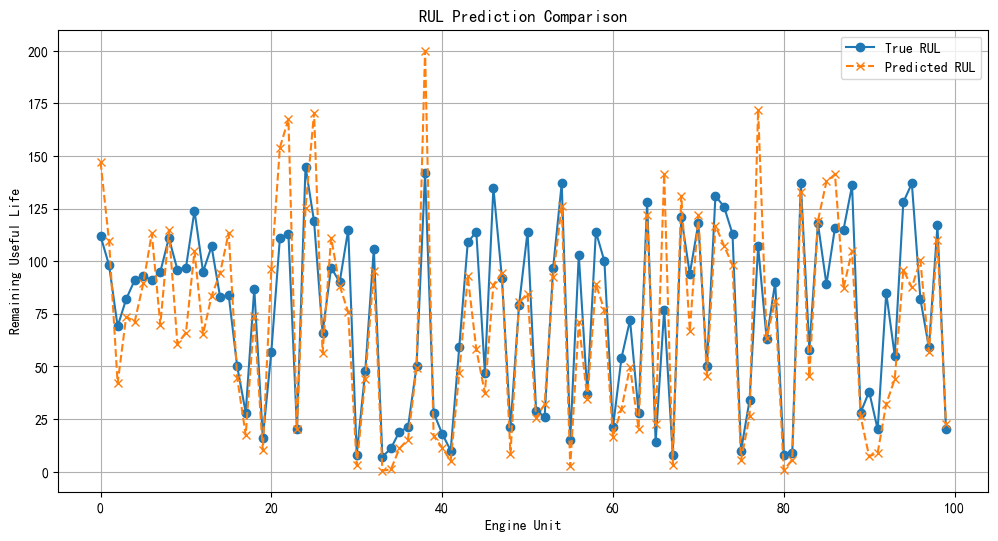

In [71]:
# Visual comparison between predicted and true RUL
plt.figure(figsize=(12, 6))
plt.plot(test_rul, label='True RUL', marker='o', linestyle='-')
plt.plot(y_pred, label='Predicted RUL', marker='x', linestyle='--')
plt.title('RUL Prediction Comparison')
plt.xlabel('Engine Unit')
plt.ylabel('Remaining Useful Life')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [70]:
rmse = compute_rmse(test_rul, y_pred)
# Print RMSE
print(f"Test Set Evaluation Metrics:")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

Test Set Evaluation Metrics:
Root Mean Square Error (RMSE): 24.08
